In [0]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
from keras import applications
from tensorflow.python.client import device_lib
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.layers import GlobalAveragePooling2D
from keras.models import Model

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((299, 299))
image_size = 0
directory_root = '/content/drive/My Drive/Colab Notebooks/Tugas 3 Deep Learning/Dataset Coklat'
height, width = 299, 299
depth=3
epochs, batch_size = 50, 32

In [0]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("ERROR: Creating Directory. -> " + directory)
        sys.exit(0)

In [0]:
create_folder('/content/weights')

In [0]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Moldy_Cocoa ...
[INFO] Processing Broken_Beans_Cocoa ...
[INFO] Processing Fermented_Cocoa ...
[INFO] Processing Unfermented_Cocoa ...
[INFO] Processing Bean_Fraction_Cocoa ...
[INFO] Processing Whole_Beans_Cocoa ...
[INFO] Image loading completed


In [0]:
image_size = len(image_list)
image_size

614

In [0]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
print(label_binarizer.classes_)

['Bean_Fraction_Cocoa' 'Broken_Beans_Cocoa' 'Fermented_Cocoa'
 'Moldy_Cocoa' 'Unfermented_Cocoa' 'Whole_Beans_Cocoa']


In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [0]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
model = applications.Xception(weights = "imagenet", include_top = False, input_shape = (height, width, 3))



model.summary()













83689472/83683744 [==============================] - 3s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________

In [0]:
custom_layer = model.output
custom_layer = GlobalAveragePooling2D()(custom_layer)
custom_layer = Dense(256, activation="relu")(custom_layer)
custom_layer = Dropout(0.5)(custom_layer)
custom_layer = Dense(256, activation="relu")(custom_layer)
output_layer = Dense(6, activation="softmax")(custom_layer)
res_model = Model(input = model.input, output = output_layer)


res_model.summary()

In [0]:
# for i in model.layers[0: 26]:
#     i.trainable = False

#checkpoint = ModelCheckpoint(filepath="/content/weights/xception_new.hdf5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')


res_model.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics = ['accuracy'])
History = res_model.fit(x_train, y_train, epochs = 100, shuffle=True, validation_data=(x_test, y_test), verbose=1,)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys




Train on 491 samples, validate on 123 samples
Epoch 1/100
491/491 [==============================] - 28s 57ms/step - loss: 0.9689 - acc: 0.6538 - val_loss: 2.7602 - val_acc: 0.6016
Epoch 2/100
491/491 [==============================] - 13s 26ms/step - loss: 0.5513 - acc: 0.8147 - val_loss: 3.1552 - val_acc: 0.6260
Epoch 3/100
491/491 [==============================] - 13s 26ms/step - loss: 0.4510 - acc: 0.8534 - val_loss: 2.9136 - val_acc: 0.6260
Epoch 4/100
491/491 [==============================] - 13s 26ms/step - loss: 0.4374 - acc: 0.8758 - val_loss: 6.8844 - val_acc: 0.3333
Epoch 5/100
491/491 [==============================] - 13s 26ms/step - loss: 0.3461 - acc: 0.8859 - val_loss: 4.5155 - val_acc: 0.6260
Epoch 6/100
491/491 [==============================] - 13s 26ms/step - loss: 0.3173 - acc: 0.9308 - val_loss: 5.4100 - val_acc: 0.6179
Epoch 7/100
491/491 [==============================] - 13s 26ms/step - loss: 0.2781 - acc: 0.9165 - val_loss: 8.3795 - val_acc: 0.4309
Epoch 8

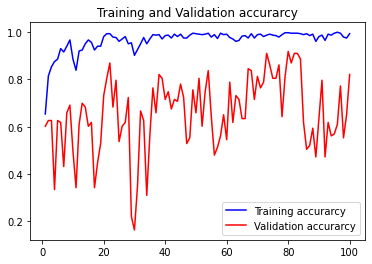

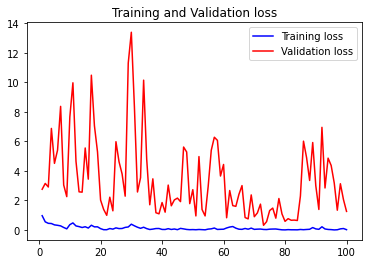

In [0]:
acc = History.history['acc']
val_acc = History.history['val_acc']
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [0]:
print("[INFO] Calculating model accuracy")
scores = res_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
123/123 [==============================] - 1s 6ms/step
Test Accuracy: 82.11382094437514
